# CG-method for TV-like regularization
We implement an algorithm, leveraging the [conjugate gradient(CG) method](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm) to solve the inverse problem
$$Ax\approx y^\delta$$
with a [total-variation-like regularization](https://en.wikipedia.org/wiki/Total_variation_denoising#2D_signal_images), specifically, we minimize
$$L:=\frac{1}{2}\|Ax-y^\delta\|_2^2 +  \frac{\lambda}{2} \|\nabla x\|_2^2,$$
where $\nabla x$ denotes the spatial derivative of $x$.

We assume $A\in\mathbb{R}^{m\times n^2}$ to be the forward operator and $x\in\mathbb{R}^{n^2}$ to be a vectorized $n\times n$ gray-scale image.

We approximate 
$$\|\nabla x\|_2^2 = \|\tilde V x\|^2 + \|\tilde H x\|^2$$
where $\tilde V$ and $\tilde H$ look like this:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


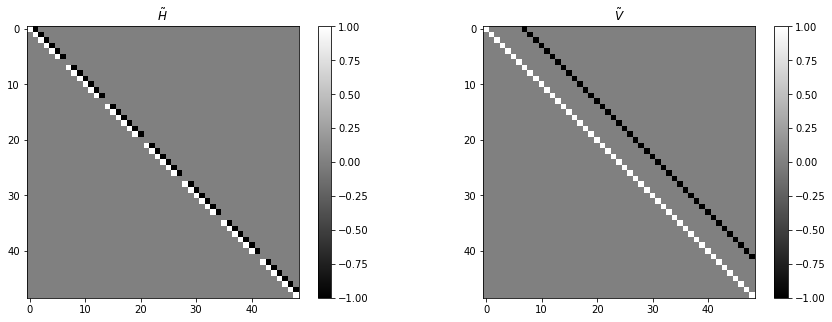

In [2]:
n = 7

H_tilde = np.eye(n*n)
H_tilde[:-1,1:] -= np.eye(n*n-1)
for i in np.arange(0, n*n, n)[1:]:
    H_tilde[i-1] *= 0

V_tilde = np.eye(n*n)
V_tilde[:-n,n:] -= np.eye(n*n-n)

plt.subplot(121), plt.imshow(H_tilde, cmap='gray')
plt.title(r"$\tilde H$")
plt.colorbar()

plt.subplot(122), plt.imshow(V_tilde, cmap='gray')
plt.title(r"$\tilde V$")
plt.colorbar()

fig = plt.gcf()
fig.set_size_inches(15,5)
plt.show()

To find a minimum we set
$$0 = (\partial_x L)^T$$
Since
$$(\partial_x L)^T = A^T\left(Ax-y^\delta\right) + \lambda \left(H + V\right),$$
where $H:=\tilde H^T \tilde H$ and $V:=\tilde V^T \tilde V$, we have (assuming the inverse exists)
$$x = \left[A^TA + \lambda\left(H+V\right) \right]^{-1} A^T y^\delta.$$

Since all of this is symmetric (and since invertible, positive definite) we can apply the CG-method.

To not have to hold $H$ and $V$ in memory and apply them efficiently we define the following functions, which allow us to multiply a vector by $H$ and $V$ efficiently.

In [3]:
def timesH(x, n):
    idx = np.arange(len(x.flatten()))
    foo = 2*np.copy(x)
    # Diagonal
    foo[::n] -= x[::n]
    foo[n-1::n] -= x[n-1::n]

    #Upper part
    foo[:-1] -= x[1:]
    foo[idx[::n][1:] - 1] += x[idx[::n][1:]]
    foo[-1] += x[-1]
    
    #Lower part
    foo[1:] -= x[:-1]
    foo[idx[::n][1:]] += x[idx[::n][1:]-1]
    
    return foo

In [4]:
def timesV(x, n):
    foo = np.copy(x)
    foo[n:] *= 2
    foo[:-n] -= x[n:]
    foo[n:] -= x[:-n]
    return foo

For simplicity we define
$$M:=A^TA + \lambda\left(H+V\right).$$

All of this leads to the following [CG-method](https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm) based function.

In [5]:
def tv_like_reconstruction(A, y, lamb, epsilon_cauchy=1e-6):
    n = int(np.sqrt(A.shape[1]))
    def timesM(x):
        return np.dot(A.T, np.dot(A, x)) + lamb * (timesH(x, n) + timesV(x, n))
    
    b = np.dot(A.T, y)
    
    x = np.zeros(n*n)
    
    # Begin CG method
    r = b - timesM(x)
    p = r
    eps = epsilon_cauchy * np.linalg.norm(b)
    
    if np.linalg.norm(r) <= eps:
        return x
    
    i = 0
    while True:
        i += 1
        Mp = timesM(p)
        alpha = np.inner(r, r) / np.inner(p, Mp)
        x = x + alpha * p
        old_r = r
        r = r - alpha * Mp
        if np.linalg.norm(r) < eps:
            return x
        beta = np.inner(r, r) / np.inner(old_r, old_r)
        p = r + beta * p

Simple example for a radom compressed sensing matrix $A$ and a simple image $x$ with pixels between $0$ and $1$.

In [6]:
n = 32

# Define Image
x = np.zeros([n,n])
x[n//2:,n//2:] = 1

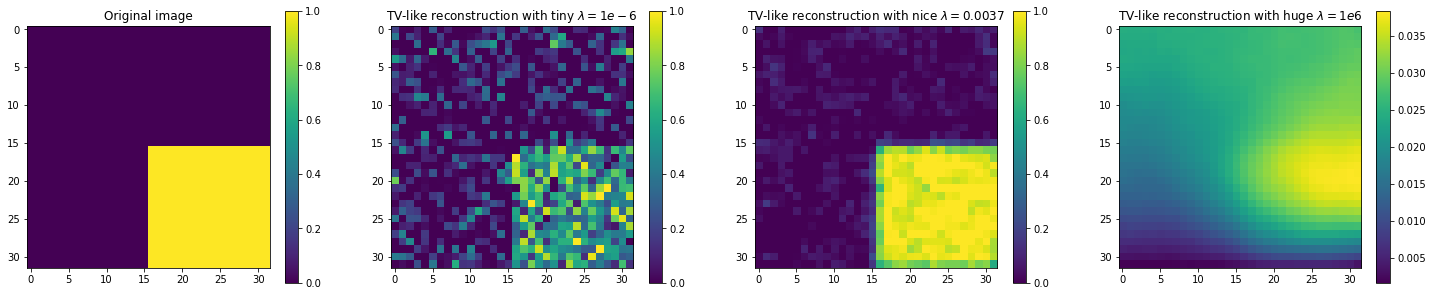

In [7]:
# Define compressed sensing matrix
A = np.random.normal(0, 1, [n*n//2,n*n])
# Calculate measurement
y = np.dot(A, x.flatten())

plt.subplot(141)
plt.imshow(x)
plt.title("Original image")
plt.colorbar()

x_tv = tv_like_reconstruction(A, y, 1e-6).reshape(n,n)
plt.subplot(142), plt.imshow(np.clip(x_tv, 0, 1))
plt.title(r"TV-like reconstruction with tiny $\lambda = 1e-6$")
plt.colorbar()

x_tv = tv_like_reconstruction(A, y, 0.0037).reshape(n,n)
plt.subplot(143), plt.imshow(np.clip(x_tv, 0, 1))
plt.title(r"TV-like reconstruction with nice $\lambda = 0.0037$")
plt.colorbar()

x_tv = tv_like_reconstruction(A, y, 1e6).reshape(n,n)
plt.subplot(144), plt.imshow(np.clip(x_tv, 0, 1))
plt.title(r"TV-like reconstruction with huge $\lambda = 1e6$")
plt.colorbar()

fig = plt.gcf()
fig.set_size_inches(25,5)
plt.show()

Reconstructions with ill-conditioned matrix and noisy measurments.

In [8]:
# Create ill-conditioned matrix
A = np.random.normal(0, 1, [n*n//2,n*n])
for _ in range(20):
    A *= np.random.normal(0, 1, [n*n//2,n*n])
# Calculate measurement
y = np.dot(A, x.flatten())

# Create noisy measurement
noise = np.random.normal(0, 1, y.shape)
y_delta = y + noise

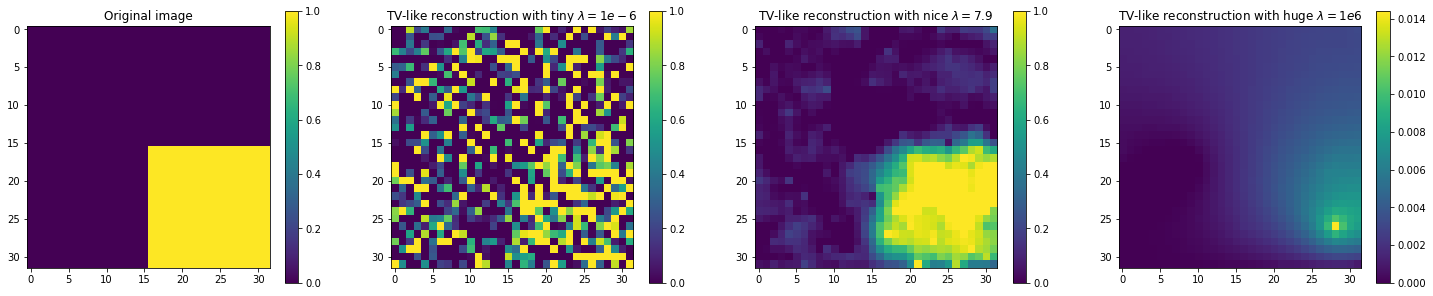

In [9]:
plt.subplot(141)
plt.imshow(x)
plt.title("Original image")
plt.colorbar()

x_tv = tv_like_reconstruction(A, y_delta, 1e-6).reshape(n,n)
plt.subplot(142), plt.imshow(np.clip(x_tv, 0, 1))
plt.title(r"TV-like reconstruction with tiny $\lambda = 1e-6$")
plt.colorbar()

x_tv = tv_like_reconstruction(A, y_delta, 7.9).reshape(n,n)
plt.subplot(143), plt.imshow(np.clip(x_tv, 0, 1))
plt.title(r"TV-like reconstruction with nice $\lambda = 7.9$")
plt.colorbar()

x_tv = tv_like_reconstruction(A, y_delta, 1e6).reshape(n,n)
plt.subplot(144), plt.imshow(np.clip(x_tv, 0, 1))
plt.title(r"TV-like reconstruction with huge $\lambda = 1e6$")
plt.colorbar()

fig = plt.gcf()
fig.set_size_inches(25,5)
plt.show()